In [1]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
import numpy as np
from torch import FloatTensor
import matplotlib.pyplot as plt
import torch
import pandas as pd

have a 2d gaussian distribution with 0 mean and I covariance matrix. 
add a 3rd feature whos value is (1,2,3) if normal and (18, 91, 20) if outlier.

In [2]:
np.random.seed(20)

# Parameters
num_groups = 20
num_points_per_group = 25
num_features = 3  # Two Gaussian features + one label
num_normal = 18
num_anomalous = 2

# Generate data
dataset = []
for i in range(num_groups):
    if i < num_normal:
        label = np.random.choice([1, 2, 3])  
    else:
        label = np.random.choice([18, 19, 20]) 
    points = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0], [0, 1]], size=num_points_per_group)
    feature_3 = np.full((num_points_per_group, 1), label)  # Feature 3 as a column
    group_data = np.hstack([points, feature_3]) 
    dataset.append(group_data)

# Convert dataset into a 3D NumPy array
final_dataset = np.array(dataset)  

In [3]:
final_dataset

array([[[-9.50443117e-01,  1.50227571e+00,  3.00000000e+00],
        [ 2.12601055e+00,  2.49155430e-01,  3.00000000e+00],
        [-6.20642157e-01, -8.34532935e-01,  3.00000000e+00],
        ...,
        [ 5.82383646e-01,  6.18822645e-01,  3.00000000e+00],
        [ 1.72222527e+00,  9.66258167e-01,  3.00000000e+00],
        [-9.54509488e-01,  1.88129696e+00,  3.00000000e+00]],

       [[-5.55185797e-01,  1.50856026e-03,  2.00000000e+00],
        [ 8.57093817e-01,  1.48114365e+00,  2.00000000e+00],
        [-2.19661122e-01,  1.50339816e+00,  2.00000000e+00],
        ...,
        [-1.05616900e+00,  5.54274933e-01,  2.00000000e+00],
        [-9.50018010e-01,  8.57999351e-01,  2.00000000e+00],
        [-5.32079247e-01,  1.12575886e+00,  2.00000000e+00]],

       [[ 8.87426405e-01, -1.75328984e-01,  3.00000000e+00],
        [ 1.11319110e+00, -1.02019706e+00,  3.00000000e+00],
        [-1.87637475e+00,  6.13533650e-01,  3.00000000e+00],
        ...,
        [-4.56576371e-01, -3.91487027e-01,

In [4]:
classifier = OneClassSMMClassifier(nu=0.3)
# classifier = OneClassSMM(0.1, 0.3)

In [5]:
classifier.fit(final_dataset)

In [6]:
decision, y_pred = classifier.predict(final_dataset)

In [7]:
count_neg_1 = np.count_nonzero(y_pred == -1)
count_pos_1 = np.count_nonzero(y_pred == 1)

print(f"Count of -1: {count_neg_1}")
print(f"Count of +1: {count_pos_1}")

Count of -1: 2
Count of +1: 18


In [8]:
decision

array([ 0.11242054,  0.31838771,  0.11187805,  0.15850175,  0.21189908,
        0.10821257,  0.10480649,  0.24701772,  0.16701512,  0.10822634,
        0.39368203,  0.10011747,  0.19042518,  0.25185799,  0.03523899,
        0.33754444,  0.1082225 ,  0.23388855, -0.38492265, -0.29188141])

In [9]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[18, 19]

In [10]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=final_dataset, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=final_dataset, num_coalitions=2**final_dataset[0].shape[1])

c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:19: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:19: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:19: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
100%|██████████| 7/7 [00:00<00:00, 21.84it/s]


In [11]:
mean_stochastic_shapley_values = ocsmm_shap.return_deterministic_shapley_values()

In [12]:
mean_stochastic_shapley_values

tensor([[ 0.0574,  0.1569, -0.0164,  0.0358,  0.0433,  0.0759,  0.0126,  0.0275,
          0.0574,  0.0618,  0.1026,  0.0343,  0.0467,  0.0790,  0.0142,  0.1149,
          0.0348,  0.0101, -0.0532, -0.0182],
        [ 0.0466,  0.0217,  0.0608,  0.0217,  0.0185,  0.0179,  0.0236,  0.0801,
          0.0832,  0.0151,  0.1239,  0.0080,  0.1006,  0.0368,  0.0611,  0.0997,
          0.0187,  0.1183, -0.0303, -0.0551],
        [ 0.0092,  0.1388,  0.0665,  0.1028,  0.1492,  0.0142,  0.0687,  0.1392,
          0.0277,  0.0311,  0.1642,  0.0584,  0.0419,  0.1378, -0.0396,  0.1228,
          0.0548,  0.1074, -0.3013, -0.2186]])

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)


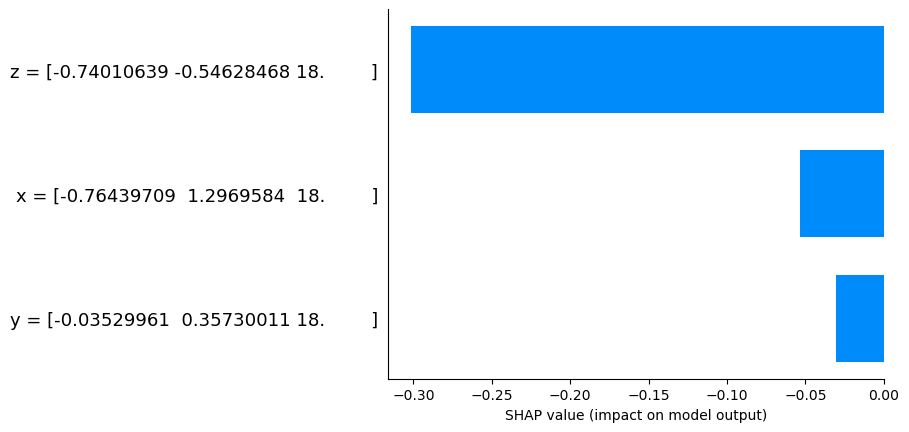

In [13]:
from src.utils.visualisation.deterministic_values import summary_plot, bar_plot, violin_plot
bar_plot(mean_stochastic_shapley_values.T[18], final_dataset[18], feature_names=['x', 'y', 'z'])

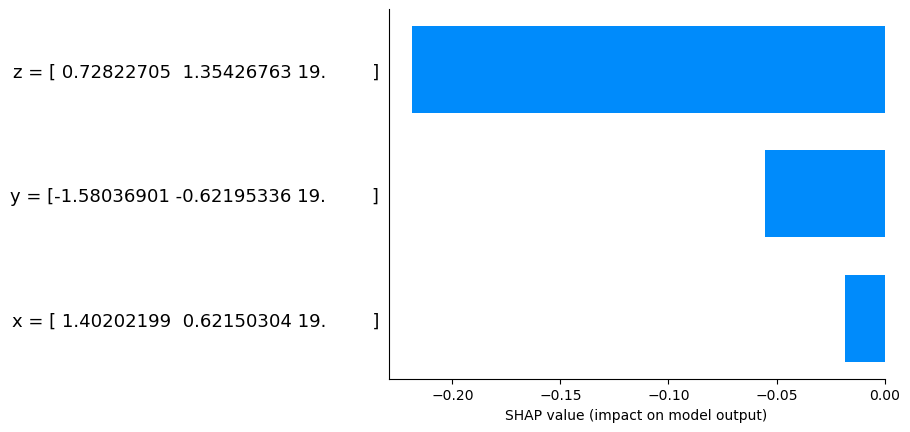

In [14]:
bar_plot(mean_stochastic_shapley_values.T[19], final_dataset[19], feature_names=['x', 'y', 'z'])

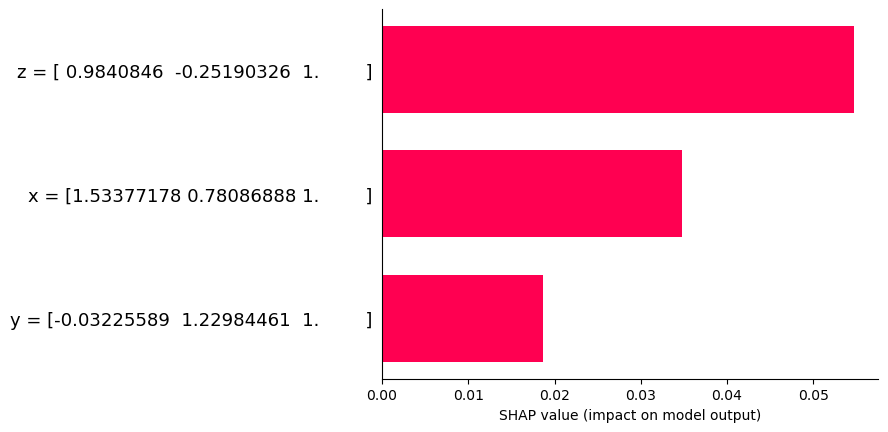

In [15]:
bar_plot(mean_stochastic_shapley_values.T[16], final_dataset[16], feature_names=['x', 'y', 'z'])

This group is not an outlier due to low value of z. Feature z is decided if a pointer is an outlier or not.

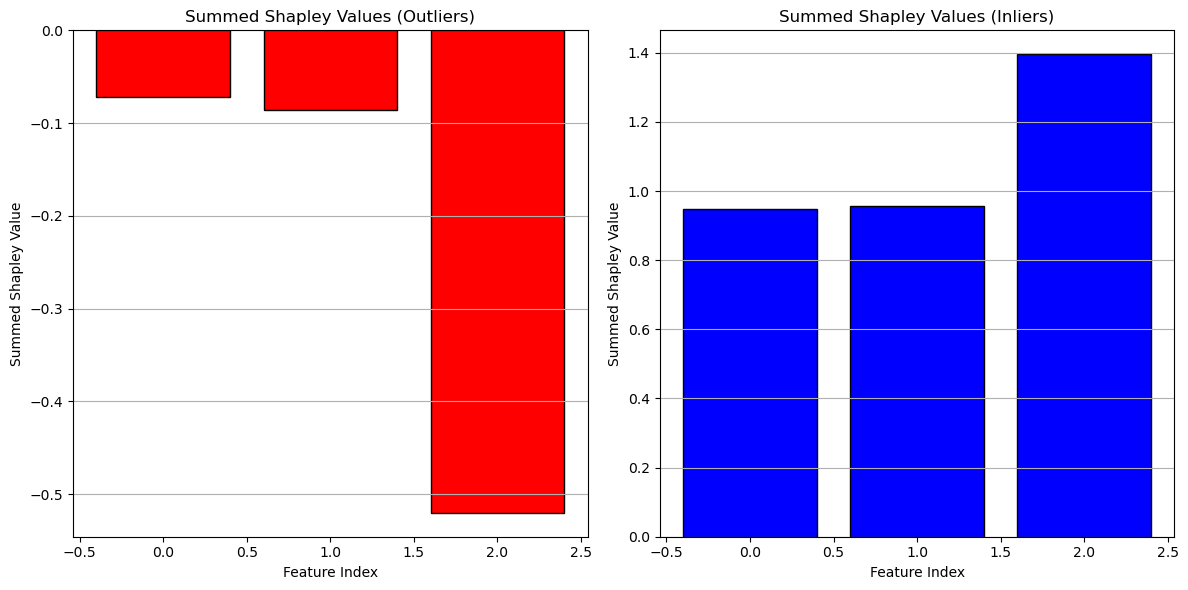

In [16]:
inlier_indices = [i for i in range(mean_stochastic_shapley_values.shape[1]) if i not in outlier_indices]

summed_outlier_shapley = mean_stochastic_shapley_values[:, outlier_indices].sum(dim=1).numpy()
summed_inlier_shapley = mean_stochastic_shapley_values[:, inlier_indices].sum(dim=1).numpy()

# Plot histogram
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Outlier Shapley Values
ax[0].bar(range(len(summed_outlier_shapley)), summed_outlier_shapley, color='red', edgecolor='black')
ax[0].set_title('Summed Shapley Values (Outliers)')
ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Summed Shapley Value')
ax[0].grid(True, axis='y')

# Inlier Shapley Values
ax[1].bar(range(len(summed_inlier_shapley)), summed_inlier_shapley, color='blue', edgecolor='black')
ax[1].set_title('Summed Shapley Values (Inliers)')
ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Summed Shapley Value')
ax[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

Eeven in the case of inliers, feature z is telling us the reasons for the prediction

The most influential feature is the feature 3, which is causing the outlier prediction